In [1]:
# !pip install tensorflow --user

In [2]:
# !jupyter nbextension enable --py widgetsnbextension

In [3]:
# !pip install catboost

In [144]:
!pip install scikit-learn==1.0.2 --user

In [180]:
import warnings
import pandas as pd
import numpy as np
import pickle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
%matplotlib inline

# Tensorflow, Keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Preprocessing
import sklearn
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error

# Clustering
from scipy import stats
from scipy.cluster.hierarchy import fcluster, dendrogram, linkage
from sklearn.cluster import KMeans

# Models
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb

# Math stats
from scipy import stats
import math

#RegEx and json
import re
from ast import literal_eval
import json
import requests
import urllib.parse

In [76]:
sklearn.__version__

'1.0.2'

In [77]:
warnings.filterwarnings('ignore')
RANDOM_SEED = 42

## 1.1 Data preprocessing

In [78]:
df = pd.read_csv('data.csv')

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [80]:
df.head()

status private pool        propertyType               street    baths  \
0    Active          NaN  Single Family Home       240 Heather Ln      3.5   
1  for sale          NaN  single-family home    12911 E Heroy Ave  3 Baths   
2  for sale          NaN  single-family home    2005 Westridge Rd  2 Baths   
3  for sale          NaN  single-family home  4311 Livingston Ave  8 Baths   
4  for sale          NaN            lot/land       1524 Kiscoe St      NaN   

                                           homeFacts fireplace  \
0  {'atAGlanceFacts': [{'factValue': '2019', 'fac...  Gas Logs   
1  {'atAGlanceFacts': [{'factValue': '2019', 'fac...       NaN   
2  {'atAGlanceFacts': [{'factValue': '1961', 'fac...       yes   
3  {'atAGlanceFacts': [{'factValue': '2006', 'fac...       yes   
4  {'atAGlanceFacts': [{'factValue': '', 'factLab...       NaN   

             city                                            schools  \
0  Southern Pines  [{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...   
1  Spokane Valley  [{'rating': ['4/10', 'None/10', '4/10'], 'data...   
2     Los Angeles  [{'rating': ['8/10', '4/10', '8/10'], 'data': ...   
3          Dallas  [{'rating': ['9/10', '9/10', '10/10', '9/10'],...   
4        Palm Bay  [{'rating': ['4/10', '5/10', '5/10'], 'data': ...   

         sqft zipcode    beds state stories mls-id PrivatePool       MlsId  \
0        2900   28387       4    NC     NaN    NaN         NaN      611019   
1  1,947 sqft   99216  3 Beds    WA     2.0    NaN         NaN   201916904   
2  3,000 sqft   90049  3 Beds    CA     1.0    NaN         yes  FR19221027   
3  6,457 sqft   75205  5 Beds    TX     3.0    NaN         NaN    14191809   
4         NaN   32908     NaN    FL     NaN    NaN         NaN      861745   

       target  
0    $418,000  
1    $310,000  
2  $2,895,000  
3  $2,395,000  
4      $5,000

In [81]:
# Let's remove duplicate columns as weel as columns which make no sence
df.drop(['private pool', 'mls-id', 'stories', 'MlsId'], axis=1, inplace=True)
df.head()

status        propertyType               street    baths  \
0    Active  Single Family Home       240 Heather Ln      3.5   
1  for sale  single-family home    12911 E Heroy Ave  3 Baths   
2  for sale  single-family home    2005 Westridge Rd  2 Baths   
3  for sale  single-family home  4311 Livingston Ave  8 Baths   
4  for sale            lot/land       1524 Kiscoe St      NaN   

                                           homeFacts fireplace  \
0  {'atAGlanceFacts': [{'factValue': '2019', 'fac...  Gas Logs   
1  {'atAGlanceFacts': [{'factValue': '2019', 'fac...       NaN   
2  {'atAGlanceFacts': [{'factValue': '1961', 'fac...       yes   
3  {'atAGlanceFacts': [{'factValue': '2006', 'fac...       yes   
4  {'atAGlanceFacts': [{'factValue': '', 'factLab...       NaN   

             city                                            schools  \
0  Southern Pines  [{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...   
1  Spokane Valley  [{'rating': ['4/10', 'None/10', '4/10'], 'data...   
2     Los Angeles  [{'rating': ['8/10', '4/10', '8/10'], 'data': ...   
3          Dallas  [{'rating': ['9/10', '9/10', '10/10', '9/10'],...   
4        Palm Bay  [{'rating': ['4/10', '5/10', '5/10'], 'data': ...   

         sqft zipcode    beds state PrivatePool      target  
0        2900   28387       4    NC         NaN    $418,000  
1  1,947 sqft   99216  3 Beds    WA         NaN    $310,000  
2  3,000 sqft   90049  3 Beds    CA         yes  $2,895,000  
3  6,457 sqft   75205  5 Beds    TX         NaN  $2,395,000  
4         NaN   32908     NaN    FL         NaN      $5,000

#### Status column

In [82]:
# Make everything uppercase#
df['status'] = df['status'].str.upper()
# df['status'].unique()
df['status'].value_counts()

FOR SALE                     199571
ACTIVE                       105207
FORECLOSURE                    6769
NEW CONSTRUCTION               5475
PENDING                        4807
                              ...  
PENDING, CONTINUE TO SHOW         1
CONTINGENT   NO SHOW              1
CONDITIONAL CONTRACT              1
PENDING W/ESCAPE CLAUSE           1
PENDING BRING BACKUP              1
Name: status, Length: 152, dtype: int64

In [83]:
# Remove rent options
df = df[df['status']  != 'FOR RENT']

In [84]:
# Fill na for now as pending
df['status'].fillna('OTHER', inplace=True)

In [85]:
# Let's create 7 main statuses 'For sale', 'Active', 'Foreclosure', 'New', 'Sold', 'Contract' and 'Pending'
types = ['FOR SALE', 'ACTIVE', 'FORECLOSURE', 'NEW', 'SOLD', 'CONTRACT', 'PENDING']
for strtype in types: 
    df['status'] = df['status'].apply(lambda x: strtype if strtype in x else x)

In [86]:
# replace the rest with Pending
df['status'] = df['status'].apply(lambda x: x if x in types else 'OTHER')
df['status'].value_counts()

FOR SALE       199571
ACTIVE         106555
OTHER           45318
FORECLOSURE     10450
NEW              6165
PENDING          5364
CONTRACT         3075
SOLD              289
Name: status, dtype: int64

#### Property Type

In [87]:
# Make upper case
df['propertyType'] = df['propertyType'].str.upper()
# Replace "-", "," and "/" as well as some types
df['propertyType'] = df['propertyType'].str.replace('-', ' ')
df['propertyType'] = df['propertyType'].str.replace('/', ' ')
df['propertyType'] = df['propertyType'].str.replace(',', '')
df['propertyType'] = df['propertyType'].str.replace(' HOME', '')
df['propertyType'] = df['propertyType'].str.replace('CONDO TOWNHOME ROW CO OP', 'CONDO')
df['propertyType'].unique()

array(['SINGLE FAMILY', 'LOT LAND', 'TOWNHOUSE', ...,
       'CABIN LODGE CONTEMPORARY CONVERTED BARN COTTAGE LOFT WITH BEDROOMS LOG POST & BEAM',
       'LAKE HOUSE SINGLE DETACHED TUDOR',
       'BILEVEL CONVERTED DWELLING LOFT WITH BEDROOMS CONDO UNIT'],
      dtype=object)

In [88]:
# Let's keep the most common types
types = list(df['propertyType'].value_counts().index)[:10]

In [89]:
# IMPORTANT about types: LAND cannot have any beds or baths, it's just piece of land

In [90]:
df.loc[df['propertyType'] == 'LAND', ['baths', 'beds']] = '0'

In [91]:
types.remove('LAND') # exclude LAND not to conflict with LOT LAND

In [92]:
for strtype in types:
    df['propertyType'] = df['propertyType'].apply(lambda x: strtype if strtype in str(x) else x)

types.append('LAND')
df['propertyType'] = df['propertyType'].apply(lambda x: x if x in types else 'OTHER')
df['propertyType'].value_counts()

SINGLE FAMILY    186586
OTHER             58529
CONDO             51481
LOT LAND          20552
TOWNHOUSE         18525
MULTI FAMILY      12086
LAND              10934
TRADITIONAL        9348
COOP               3801
RANCH              2915
HIGH RISE          2030
Name: propertyType, dtype: int64

#### Street

In [93]:
# 2 missing values, just replace then with Unknonw
df['street'].fillna('Unknownw', inplace=True)

#### Baths

In [94]:
df['baths'] = df['baths'].str.replace(',', '.')

In [95]:
# Create function for Regex
def apply_regex(column):
    df[column] = df[column].apply(lambda x: re.sub("[^0-9.]", "", str(x)))

In [96]:
apply_regex('baths')

In [97]:
# Replace the rest of strings with some numeric value
df['baths'] = df['baths'].replace('..', '10000')
df['baths'] = df['baths'].replace('', '10000')

In [98]:
# Make float type 
df['baths'] = df['baths'].astype('float')

In [99]:
df['baths'].value_counts()[:20]

2.00        103387
10000.00    100538
3.00         66642
4.00         26320
1.00         17779
2.50         13726
0.00         11139
5.00          9451
3.50          6127
1.50          4337
6.00          4302
7.00          2076
1.75          1817
4.50          1553
2.25          1459
1.25          1216
8.00          1159
2.75          1000
9.00           545
5.50           521
10.00          327
750.00         237
6.50           191
11.00          187
12.00          134
7.50            84
13.00           74
2.10            53
16.00           52
14.00           45
18.00           32
8.50            30
15.00           28
1.10            17
24.00           17
20.00           16
Name: baths, dtype: int64

In [100]:
# Assign nan where we have baths > 100 (mostly to replace 10000 which should be nan)
df.loc[df.baths > 100, 'baths'] = np.nan

#### Fireplace

In [101]:
# Here is enough to do boolean with 0 and 1 if there is a fireplace
df['fireplace'].fillna(0, inplace=True)
df.loc[df.fireplace != 0, 'fireplace'] = 1
df['fireplace'] = df['fireplace'].astype('int')

#### City

In [102]:
# Just replace city with unknown if empty
df['city'].fillna('unknown', inplace=True)
df['city'] = df['city'].str.upper()

In [103]:
# Clean city where it's not literal
df['city'] = df['city'].apply(lambda x: re.sub("[^A-Z]", "", str(x)))

In [104]:
# Check empties (69 entries we can remove)
df = df[df['city'] != ''] 

In [105]:
df = df[df['city'] != 'UNKNOWN']

#### Area (sqft)

In [106]:
# Same RegEx as for baths
apply_regex('sqft')

In [107]:
# replace ''
df['sqft'] = df['sqft'].replace('', '0')
df['sqft'] = df['sqft'].astype('float')
df.loc[df.sqft == 0, 'sqft'] = np.nan

#### Zipcode

In [108]:
# Cut long zips
df['zipcode'] = df['zipcode'].astype('str').apply(lambda x: x[:5] if len(x) > 5 else x)
# Add 0 if zip lenth is 4
df['zipcode'] = df['zipcode'].apply(lambda x: x + '0' if len(x) == 4 else x)

In [109]:
for i in df['zipcode']:
    if len(i) !=5 or i == '00000':
        print(i)

0
0
--
--
0
00000


In [110]:
# Remove the rest
df = df[(df['zipcode'] != '0') & (df['zipcode'] != '--') & (df['zipcode'] != '00000') & (df['zipcode'] != 'nan')]

#### Beds

In [111]:
# Same RegEx as for baths
apply_regex('beds')
df['beds'] = df['beds'].replace('', '10000').replace(',', '.')

In [112]:
df['beds'].value_counts()[:20]

10000    98040
3        97614
4        63639
2        47612
5        20314
0        12101
3.0       8087
6         6268
1         5737
4.0       5231
2.0       2429
7         1753
5.0       1371
8         1177
9          479
1.0        428
6.0        311
10         275
12         189
11         131
Name: beds, dtype: int64

In [113]:
# Cut one weird strings
df['beds'] = df['beds'].apply(lambda x: x[:-1] if x[-1] == '.' else x)
df['beds'] = df['beds'].astype('float')

In [114]:
# Assign nan where we have beds > 15
df.loc[df.beds > 100, 'beds'] = np.nan

#### State

In [115]:
df['state'] = df['state'].str.upper()
df['state'].unique()

array(['NC', 'WA', 'CA', 'TX', 'FL', 'PA', 'TN', 'IA', 'NY', 'OR', 'DC',
       'NV', 'AZ', 'GA', 'IL', 'NJ', 'MA', 'OH', 'IN', 'UT', 'MI', 'VT',
       'MD', 'CO', 'VA', 'KY', 'MO', 'WI', 'ME', 'MS', 'OK', 'SC', 'MT',
       'DE', 'AL', 'OT'], dtype=object)

#### PrivatePool

In [116]:
df['PrivatePool'] = df['PrivatePool'].fillna(0)
df.loc[df.PrivatePool != 0, 'PrivatePool'] = 1
df['PrivatePool'] = df['PrivatePool'].astype('int')

#### Target price

In [117]:
# Apply same regex for numeric values
apply_regex('target')

In [118]:
df.loc[df.target == '', 'target'] = np.nan

In [119]:
df['target'] = df['target'].astype('float')

In [120]:
# Check where we stand for now
df.reset_index(inplace=True, drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376713 entries, 0 to 376712
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        376713 non-null  object 
 1   propertyType  376713 non-null  object 
 2   street        376713 non-null  object 
 3   baths         275964 non-null  float64
 4   homeFacts     376713 non-null  object 
 5   fireplace     376713 non-null  int32  
 6   city          376713 non-null  object 
 7   schools       376713 non-null  object 
 8   sqft          323525 non-null  float64
 9   zipcode       376713 non-null  object 
 10  beds          277331 non-null  float64
 11  state         376713 non-null  object 
 12  PrivatePool   376713 non-null  int32  
 13  target        374237 non-null  float64
dtypes: float64(4), int32(2), object(8)
memory usage: 37.4+ MB


## 1.2 EDA Feature Engineering

### Variables look like json

#### Home Facts

In [121]:
# Check how it look like converting with literal evaluation
literal_eval(df.loc[0, 'homeFacts'])['atAGlanceFacts']

[{'factValue': '2019', 'factLabel': 'Year built'},
 {'factValue': '', 'factLabel': 'Remodeled year'},
 {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'},
 {'factValue': '', 'factLabel': 'Cooling'},
 {'factValue': '', 'factLabel': 'Parking'},
 {'factValue': None, 'factLabel': 'lotsize'},
 {'factValue': '$144', 'factLabel': 'Price/sqft'}]

In [122]:
df['homeFacts'] = df['homeFacts'].apply(lambda x: literal_eval(x)['atAGlanceFacts'])

In [123]:
# Create new variables from Home Facts TAKES FOREVER!
# for i in range(len(df)):
#     for dictionary in df['homeFacts'][i]:
#         df.loc[i, dictionary['factLabel']] = dictionary['factValue']

In [124]:
def create_column(fact_label):
    
    column = []
    for dictionary in df['homeFacts']:
        for i in range(len(dictionary)):
            if dictionary[i]['factLabel'] == fact_label:
                if dictionary[i]['factValue'] != '':
                    column.append(dictionary[i]['factValue'])
                else:
                    column.append(0)
    df[fact_label] = column

In [125]:
# Let's create new columns 
new_columns = ['Year built', 'Remodeled year', 'Heating', 'Cooling', 'Parking', 'lotsize', 'Price/sqft']

In [126]:
# Create columns and replace 0 back with nan
for i in new_columns:
    create_column(i)
    df.loc[df[i] == 0, f'{i}'] = np.nan

#### Schools

In [127]:
literal_eval(df.loc[1, 'schools'])[0]

{'rating': ['4/10', 'None/10', '4/10'],
 'data': {'Distance': ['1.65mi', '1.32mi', '1.01mi'],
  'Grades': ['9-12', '3-8', 'PK-8']},
 'name': ['East Valley High School&Extension',
  'Eastvalley Middle School',
  'Trentwood Elementary School']}

In [128]:
# Let's make our life easier and create column with max rating of nearest schools and number of schools around
df['max_rating'] = df['schools'].apply(lambda x: literal_eval(x)[0]['rating'])
df['schools_around'] = df['schools'].apply(lambda x: len(literal_eval(x)[0]['name']))

In [129]:
# Apply regex to ratings
for ratings in df['max_rating']:
    for i in range(len(ratings)):
        ratings[i] = re.sub("[^0-9.]", "0", ratings[i][:1]) ## take first digit from ratings

In [130]:
df['max_rating'] = df['max_rating'].apply(lambda x: max(x) if x != [] else 0)

In [131]:
# Replace the rest 80 schools no max rating with 0 and make it numeric
df['max_rating'] = df['max_rating'].replace('', 0)
df['schools_around'] = df['schools_around'].replace('', 0)
df[['max_rating', 'schools_around']] = df[['max_rating', 'schools_around']].astype('int')
df['max_rating'].value_counts()

7    68775
6    59974
8    58374
9    54569
5    44483
4    42379
3    27754
2    12375
0     5116
1     2914
Name: max_rating, dtype: int64

In [132]:
# Where we stand now
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376713 entries, 0 to 376712
Data columns (total 23 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          376713 non-null  object 
 1   propertyType    376713 non-null  object 
 2   street          376713 non-null  object 
 3   baths           275964 non-null  float64
 4   homeFacts       376713 non-null  object 
 5   fireplace       376713 non-null  int32  
 6   city            376713 non-null  object 
 7   schools         376713 non-null  object 
 8   sqft            323525 non-null  float64
 9   zipcode         376713 non-null  object 
 10  beds            277331 non-null  float64
 11  state           376713 non-null  object 
 12  PrivatePool     376713 non-null  int32  
 13  target          374237 non-null  float64
 14  Year built      314401 non-null  object 
 15  Remodeled year  151070 non-null  object 
 16  Heating         267672 non-null  object 
 17  Cooling   

#### Built year, remodeled year

In [133]:
# Replace string No data with nan
df['Remodeled year'] = df['Remodeled year'].replace('No Data', 0)
df.loc[0, 'Remodeled year'] = np.nan

In [134]:
# If remodeled year is null then let's assume it wsnt remodeled and fill with built year 
df.loc[df['Remodeled year'].isna(), 'Remodeled year'] = df.loc[df['Remodeled year'].isna(), 'Year built']

In [135]:
# Replace string No data with nan again because it might be applied from year built
df['Remodeled year'] = df['Remodeled year'].replace('No Data', 0)
df.loc[0, 'Remodeled year'] = np.nan

In [136]:
# Keep only remodeled year as latest year
df.drop('Year built', axis = 1, inplace = True)
df['Remodeled year'] = df['Remodeled year'].astype('float')

#### Heating, cooling, parking

In [137]:
# Keep 5 most frequent heating types
df['Heating'] = df['Heating'].str.upper()
types = list(df['Heating'].value_counts().index)[:5]

In [138]:
types.append('NO')
types

['FORCED AIR', 'OTHER', 'ELECTRIC', 'GAS', 'HEAT PUMP', 'NO']

In [139]:
df.loc[df['Heating'].isna(), 'Heating'] = 'NO'

In [140]:
for strtype in types: 
    df['Heating'] = df['Heating'].apply(lambda x: strtype if strtype in x else x)
df['Heating'] = df['Heating'].apply(lambda x: x if x in types else 'OTHER')
df['Heating'].value_counts()

FORCED AIR    140835
NO            117834
OTHER          63786
ELECTRIC       28927
GAS            15250
HEAT PUMP      10081
Name: Heating, dtype: int64

In [141]:
# For cooling just keep boolean
df.loc[(df['Cooling'].isna()) | (df['Cooling'] == 'No Data') | (df['Cooling'] == 'None'), 'Cooling'] = 0
df.loc[df['Cooling'] != 0, 'Cooling'] = 1

In [142]:
# Parking the same
df.loc[(df['Parking'].isna()) | (df['Parking'] == 'No Data') | (df['Parking'] == 'None'), 'Parking'] = 0
df.loc[df['Parking'] != 0, 'Parking'] = 1

#### Lotsize

In [143]:
# Apply regex first
apply_regex('lotsize')

In [144]:
# Do some manual corrections
df['lotsize'] = df['lotsize'].apply(lambda x: x[:-2] if x[-2:] == '..' else x)

In [145]:
# Make some replacements
df['lotsize'] = df['lotsize'].replace('', '0')
df['lotsize'] = df['lotsize'].astype('float')
df.loc[df.lotsize == 0, 'lotsize'] = np.nan

In [146]:
df.loc[~((df['sqft'].isna()) | (df['lotsize'].isna())), ['sqft', 'lotsize', 'propertyType']]

sqft  lotsize   propertyType
1       1947.0   5828.0  SINGLE FAMILY
2       3000.0   8626.0  SINGLE FAMILY
3       6457.0   8220.0  SINGLE FAMILY
5        897.0    680.0      TOWNHOUSE
6       1507.0   4996.0          OTHER
...        ...      ...            ...
376704  1829.0   7704.0  SINGLE FAMILY
376705  1895.0   7500.0    TRADITIONAL
376708  4017.0   8500.0  SINGLE FAMILY
376710  1152.0   1600.0  SINGLE FAMILY
376712  1462.0   6969.0  SINGLE FAMILY

[243256 rows x 3 columns]

In [147]:
# We can see that lotsize and sqft is not the same, remove houses without sqft as it's very important variable
df = df[~df['sqft'].isna()]

In [148]:
# Try to replace missing lotsize
df.loc[df['lotsize'].isna(), 'lotsize'] = df.loc[df['lotsize'].isna(), 'sqft']

In [149]:
# Remove lotsize
# df.drop('lotsize', axis=1, inplace=True)

#### Price per sqft

In [150]:
df[['sqft', 'lotsize', 'target', 'Price/sqft']]

sqft  lotsize     target Price/sqft
0       2900.0   2900.0   418000.0       $144
1       1947.0   5828.0   310000.0  $159/sqft
2       3000.0   8626.0  2895000.0  $965/sqft
3       6457.0   8220.0  2395000.0  $371/sqft
5        897.0    680.0   209000.0  $233/sqft
...        ...      ...        ...        ...
376707  1417.0   1417.0   799000.0       $564
376708  4017.0   8500.0  1249000.0       $311
376709  2000.0   2000.0   674999.0  $337/sqft
376710  1152.0   1600.0   528000.0  $458/sqft
376712  1462.0   6969.0   204900.0       $140

[323525 rows x 4 columns]

In [151]:
# Apply regex but not including "."
df['Price/sqft'] = df['Price/sqft'].apply(lambda x: re.sub("[^0-9]", "", str(x)))

In [152]:
# Try to restore target
df['Price/sqft'] = df['Price/sqft'].replace('', '0')
df['Price/sqft'] = df['Price/sqft'].astype('float')
df.loc[df['Price/sqft'] == 0, 'Price/sqft'] = np.nan

In [153]:
df.loc[df['target'].isna(), 'target'] = df.loc[df['target'].isna(), 'Price/sqft']*df.loc[df['target'].isna(), 'sqft']

In [154]:
# Drop useless columns
df.drop(['Price/sqft', 'homeFacts', 'schools'], axis=1, inplace=True)

In [155]:
# Change types for heating and cooling
df[['Parking', 'Cooling']] = df[['Parking', 'Cooling']].astype('int')

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323525 entries, 0 to 376712
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          323525 non-null  object 
 1   propertyType    323525 non-null  object 
 2   street          323525 non-null  object 
 3   baths           260197 non-null  float64
 4   fireplace       323525 non-null  int32  
 5   city            323525 non-null  object 
 6   sqft            323525 non-null  float64
 7   zipcode         323525 non-null  object 
 8   beds            259873 non-null  float64
 9   state           323525 non-null  object 
 10  PrivatePool     323525 non-null  int32  
 11  target          321858 non-null  float64
 12  Remodeled year  305345 non-null  float64
 13  Heating         323525 non-null  object 
 14  Cooling         323525 non-null  int32  
 15  Parking         323525 non-null  int32  
 16  lotsize         323525 non-null  float64
 17  max_rating

## Descriptive statistics

In [157]:
# Remove outliers function with z-score
def remove_outliers(df, column):
    df['z_score'] = stats.zscore(df[column])
    df = df.loc[df['z_score'].abs()<=3]
    df.drop('z_score', axis=1, inplace=True)
    return df

#### Remove outliers

In [158]:
# Apply hard filter for sqft and target
# Let's say Price cannot be lower than 1000 and higher than 100,000,000, sqft is between 100 and 60000
df = df[~((df['target'] > 100000000) | (df['target'] < 1000) | (df['sqft'] > 60000) | (df['sqft'] < 100))]

In [159]:
# Drop nan where target is null
df = df[~df['target'].isna()]

In [160]:
# Apply z-score for sqft and target
df = remove_outliers(df, 'sqft')
df = remove_outliers(df, 'target')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314030 entries, 0 to 376712
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          314030 non-null  object 
 1   propertyType    314030 non-null  object 
 2   street          314030 non-null  object 
 3   baths           253430 non-null  float64
 4   fireplace       314030 non-null  int32  
 5   city            314030 non-null  object 
 6   sqft            314030 non-null  float64
 7   zipcode         314030 non-null  object 
 8   beds            252851 non-null  float64
 9   state           314030 non-null  object 
 10  PrivatePool     314030 non-null  int32  
 11  target          314030 non-null  float64
 12  Remodeled year  296575 non-null  float64
 13  Heating         314030 non-null  object 
 14  Cooling         314030 non-null  int32  
 15  Parking         314030 non-null  int32  
 16  lotsize         314030 non-null  float64
 17  max_rating

In [161]:
# Numeric variables 'Remodeled year' not included as it's out of memory
profile = ProfileReport(df[['target', 'sqft', 'beds', 'baths', 'schools_around', 'max_rating']], title="Houses pricing", explorative=True)
profile

In [162]:
# Remodeled year
df['Remodeled year'].value_counts()

2019.0    30522
2006.0     8841
2005.0     7730
2007.0     7106
2018.0     6922
          ...  
1858.0        1
1857.0        1
1843.0        1
1845.0        1
1019.0        1
Name: Remodeled year, Length: 219, dtype: int64

In [163]:
# Replace 1019 as not realistic, other nan values fill out with average for house type
df.loc[df['Remodeled year'] == 1019, 'Remodeled year'] = 2019
for propertyType in list(df['propertyType'].unique()):
    df.loc[(df['Remodeled year'].isna()) & (df['propertyType'] == propertyType), 'Remodeled year'] = df[df['propertyType'] == propertyType]['Remodeled year'].mean()

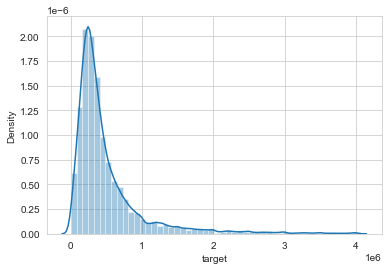

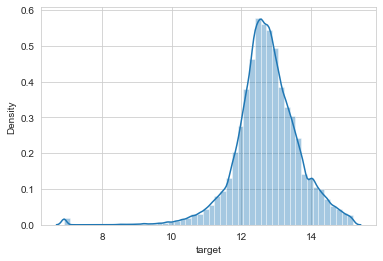

In [164]:
# Brief look at target
def dist_plot(df, column):
    x = df[column]
    sns.set_style('whitegrid')
    sns.distplot(x)
    plt.show()
    
    # LOGARITHMS
    x = np.log(df[column])
    sns.distplot(x)
    plt.show()
    
dist_plot(df, 'target')

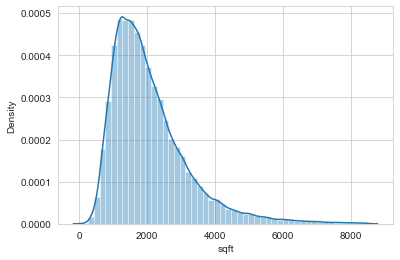

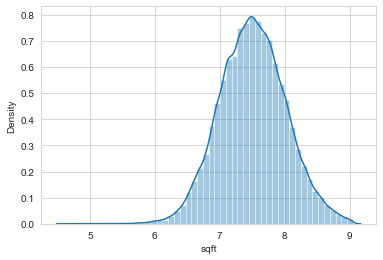

In [165]:
# And other numeric variables
dist_plot(df, 'sqft')

### Create new variables

#### Price/sqft for City and State


In [166]:
df['Price_sqft'] = df['target']/df['sqft']
for state in list(df['state'].unique()):
    df.loc[(df['state'] == state), 'Price_sqft_state'] = df[df['state'] == state]['Price_sqft'].mean()
    
for city in list(df['city'].unique()):
    df.loc[(df['city'] == city), 'Price_sqft_city'] = df[df['city'] == city]['Price_sqft'].mean()

for zipcode in list(df['zipcode'].unique()):
    df.loc[(df['zipcode'] == zipcode), 'Price_sqft_zip'] = df[df['zipcode'] == zipcode]['Price_sqft'].mean() 

In [167]:
# Save df
df.to_csv('half_preproc_data.csv', index=False)

In [168]:
df = pd.read_csv('half_preproc_data.csv')

## 1.3 Create model to predict missing values for  "beds" and "baths"

In [169]:
def preproc(df, column):
    
    # Keep columns we will use and split variables
    df_preproc = df[['propertyType', 'PrivatePool', 'sqft', 'target', column]] 
    df_preproc.loc[df_preproc[column].isna(), 'sample'] = 0
    df_preproc.loc[~df_preproc[column].isna(), 'sample'] = 1
    
    # Remove type land because it wont affect baths and beds
    df_preproc = df_preproc[df_preproc['propertyType'] != 'LAND']
    
    # Encode propertyType
    df_preproc['propertyType'] = df_preproc['propertyType'].astype('category').cat.codes
    
    # !!!! Logarithms
    df_preproc[['sqft', 'target']] = np.log(df_preproc[['sqft', 'target']])   
    
    # Data normalization
    scaler = RobustScaler() 
    df_preproc[['sqft', 'target']] = scaler.fit_transform(df_preproc[['sqft', 'target']])
    
    
    # Train test data
    train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
    test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)
    train_data[column] = train_data[column].astype('int')
    
    # Outliers from sqft and target
    for col in ['sqft', 'target']: 
        train_data['z_score'] = stats.zscore(train_data[col])
        train_data = train_data.loc[train_data['z_score'].abs()<=3]
        train_data.drop('z_score', axis=1, inplace=True)
    
    # Cut target 
    train_data = train_data[train_data[column] < 8]
       
    y = train_data[column].values     # target variable
    X = train_data.drop([column], axis=1)
    X_pred = test_data.drop([column], axis=1)
    
    # Split X, y
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)
    
    return X_pred, X_train, X_test, y_train, y_test

In [170]:
def run_cat_boost(X_pred, X_train, X_test, y_train, y_test):
    
    model = CatBoostClassifier(iterations = 500,
                              random_seed = RANDOM_SEED,
                              eval_metric='Accuracy',
                                  )
    
    model.fit(X_train, y_train,
             eval_set=(X_test, y_test),
             verbose_eval=100,
             use_best_model=True,
             plot=True
             )
    
    test_predict_catboost = model.predict(X_test)
    missing_values = model.predict(X_pred)
    
    return missing_values

In [171]:
# Beds
X_pred, X_train, X_test, y_train, y_test = preproc(df, 'beds')

In [172]:
beds = run_cat_boost(X_pred, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.156416
0:	learn: 0.5618756	test: 0.5599154	best: 0.5599154 (0)	total: 153ms	remaining: 1m 16s
100:	learn: 0.6099579	test: 0.6085406	best: 0.6087018 (97)	total: 14.4s	remaining: 56.7s
200:	learn: 0.6119219	test: 0.6095478	best: 0.6098499 (192)	total: 27.8s	remaining: 41.3s
300:	learn: 0.6137096	test: 0.6106758	best: 0.6106758 (300)	total: 41.2s	remaining: 27.2s
400:	learn: 0.6148779	test: 0.6107765	best: 0.6109377 (304)	total: 54.4s	remaining: 13.4s
499:	learn: 0.6165247	test: 0.6107161	best: 0.6109981 (461)	total: 1m 8s	remaining: 0us

bestTest = 0.6109980864
bestIteration = 461

Shrink model to first 462 iterations.


In [173]:
# Accuracy around 61% not the best but still better than avearage or guessing
beds_to_df = []
for i in beds:
    beds_to_df.append(i[0])
df.loc[df['beds'].isna(), 'beds'] = beds_to_df

In [174]:
# Baths
X_pred, X_train, X_test, y_train, y_test = preproc(df, 'baths')

In [175]:
baths = run_cat_boost(X_pred, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.156442
0:	learn: 0.5827811	test: 0.5849498	best: 0.5849498 (0)	total: 137ms	remaining: 1m 8s
100:	learn: 0.6237583	test: 0.6236241	best: 0.6236241 (100)	total: 13.4s	remaining: 52.9s
200:	learn: 0.6276338	test: 0.6252222	best: 0.6255219 (191)	total: 26.7s	remaining: 39.8s
300:	learn: 0.6297813	test: 0.6254819	best: 0.6256218 (283)	total: 40.2s	remaining: 26.6s
400:	learn: 0.6312496	test: 0.6254819	best: 0.6258615 (318)	total: 54.8s	remaining: 13.5s
499:	learn: 0.6328028	test: 0.6258815	best: 0.6262810 (493)	total: 1m 8s	remaining: 0us

bestTest = 0.6262809884
bestIteration = 493

Shrink model to first 494 iterations.


In [176]:
baths_to_df = []
for i in baths:
    baths_to_df.append(i[0])
df.loc[df['baths'].isna(), 'baths'] = baths_to_df

In [177]:
# Final df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314030 entries, 0 to 314029
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   status            314030 non-null  object 
 1   propertyType      314030 non-null  object 
 2   street            314030 non-null  object 
 3   baths             314030 non-null  float64
 4   fireplace         314030 non-null  int64  
 5   city              314030 non-null  object 
 6   sqft              314030 non-null  float64
 7   zipcode           314030 non-null  int64  
 8   beds              314030 non-null  float64
 9   state             314030 non-null  object 
 10  PrivatePool       314030 non-null  int64  
 11  target            314030 non-null  float64
 12  Remodeled year    314030 non-null  float64
 13  Heating           314030 non-null  object 
 14  Cooling           314030 non-null  int64  
 15  Parking           314030 non-null  int64  
 16  lotsize           31

In [178]:
df.head()

status   propertyType               street  baths  fireplace  \
0    ACTIVE  SINGLE FAMILY       240 Heather Ln    3.5          1   
1  FOR SALE  SINGLE FAMILY    12911 E Heroy Ave    3.0          0   
2  FOR SALE  SINGLE FAMILY    2005 Westridge Rd    2.0          1   
3  FOR SALE  SINGLE FAMILY  4311 Livingston Ave    8.0          1   
4  FOR SALE      TOWNHOUSE    1624 S Newkirk St    2.0          0   

            city    sqft  zipcode  beds state  ...     Heating  Cooling  \
0  SOUTHERNPINES  2900.0    28387   4.0    NC  ...   HEAT PUMP        0   
1  SPOKANEVALLEY  1947.0    99216   3.0    WA  ...          NO        0   
2     LOSANGELES  3000.0    90049   3.0    CA  ...  FORCED AIR        1   
3         DALLAS  6457.0    75205   5.0    TX  ...  FORCED AIR        1   
4   PHILADELPHIA   897.0    19145   2.0    PA  ...  FORCED AIR        1   

   Parking lotsize  max_rating  schools_around  Price_sqft  Price_sqft_state  \
0        0  2900.0           7               8  144.137931        171.305060   
1        0  5828.0           4               3  159.219312        345.901758   
2        1  8626.0           8               3  965.000000        480.531056   
3        1  8220.0           9               4  370.915286        172.787416   
4        0   680.0           0               0  232.998885        198.298056   

   Price_sqft_city  Price_sqft_zip  
0       181.025683      181.025683  
1       151.160727      157.744031  
2       618.779736      858.633077  
3       232.665713      411.811203  
4       211.186647      211.207771  

[5 rows x 23 columns]

In [179]:
# Save preprocessed df
df.to_csv('data_processed.csv', index=False)

### 1.4 Parse coordinates (will be used for visualization)

In [183]:
df_street = df[['street', 'state', 'zipcode']]

In [ ]:
# We will use street and zip to get coordinates
for i in range(len(df_street)):
    address = df_street.loc[i, 'street'] + ', ' + df_street.loc[i, 'state'] + ' ' + df_street.loc[i, 'zipcode'].astype('str')
    url = url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'
    response = requests.get(url).json()
    if len(response) > 0:
        df_street.loc[i, 'lat'] = round(float(response[0]['lat']), 4)
        df_street.loc[i, 'lon'] = round(float(response[0]['lon']), 4)
    else:
        df_street.loc[i, ['lat', 'lon']] = np.nan

In [ ]:
df

In [ ]:
# Save preprocessed df
df.to_csv('data_processed.csv', index=False)

## 2. Base model

In [72]:
data = pd.read_csv('data_processed.csv')
df = data.copy()

In [44]:
# I will use zipcode only not street and change types for schools
df.drop('street', axis=1, inplace=True)
df[['max_rating', 'schools_around']] = df[['max_rating', 'schools_around']].astype('float')
df['zipcode'] = df['zipcode'].astype('str')

In [45]:
# Split columns by category
def split_columns(df):
    boolean = []
    numeric = []
    category = []
    for i in list(df.dtypes.index):
        if df.dtypes[i] == 'object':
            category.append(i)
        elif df.dtypes[i] == 'float64':
            numeric.append(i)
        else:
            boolean.append(i)
    return boolean, numeric, category

In [46]:
boolean, numeric, category = split_columns(df)

### 2.1 Correlation analysis

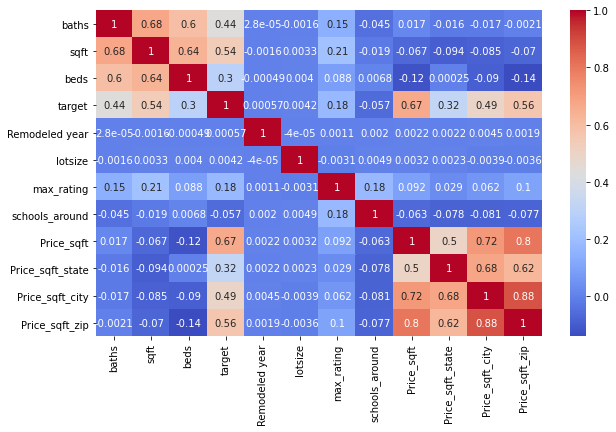

In [47]:
# Build heatmap for numeric variables
def corr_heatmap(df, columns):
    correlation = df[columns].corr()
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation, annot=True, cmap='coolwarm')
    plt.show()
    
corr_heatmap(df, numeric)

IMPORTANT NOTE: We cannot take price per sqft because it was derived directly from target price 

In [48]:
# Remove some columns
df.drop(['Price_sqft', 'lotsize', 'Remodeled year', 'schools_around'], axis=1, inplace=True)
# df.drop(['Price_sqft', 'Price_sqft_city', 'Price_sqft_state', 'Price_sqft_zip', 'lotsize', 'Remodeled year', 'schools_around'], axis=1, inplace=True)
# df.drop('Price_sqft', axis=1, inplace=True)

In [49]:
# Update columns
boolean, numeric, category = split_columns(df)

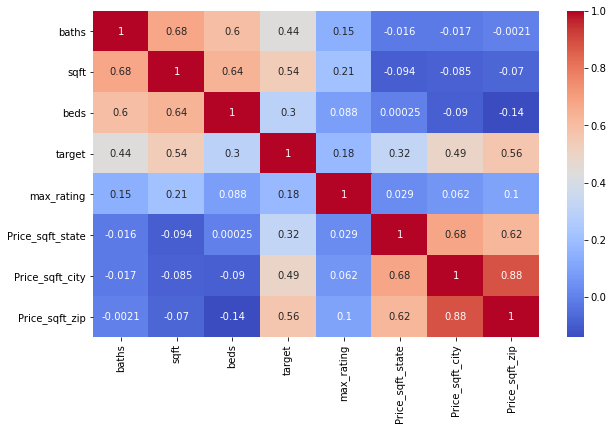

In [50]:
corr_heatmap(df, numeric)

In [51]:
numeric.remove('target')

In [52]:
# F test for category columns
def f_test(df, columns):
    df_f = df.copy()
    enc = OrdinalEncoder()
    df_f[columns] = enc.fit_transform(df_f[columns])
    col_test = pd.Series(f_regression(df_f[columns], df_f['target'])[0], index = columns)
    col_test.sort_values(inplace = True)
    col_test.plot(kind = 'barh')

In [53]:
df.dropna(inplace=True)

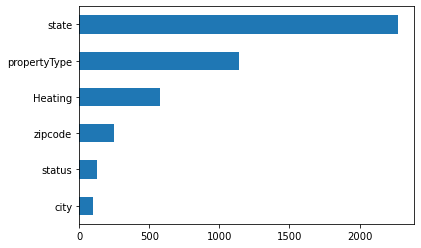

In [54]:
f_test(df, category)

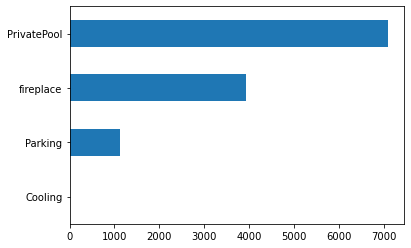

In [55]:
f_test(df, boolean)

In [56]:
# Drop cooling
df.drop('Cooling', axis=1, inplace=True)

In [57]:
# df.drop('PrivatePool', axis=1, inplace=True)

## Clusters idea

In [58]:
# Preparation new standartized A
scaler = StandardScaler()
X = scaler.fit_transform(df[['sqft', 'target', 'beds', 'baths']])
cols = df[['sqft', 'target', 'beds', 'baths']].columns
A = pd.DataFrame(data=X, columns=cols)

In [59]:
# See the contribution of each column
n_PC = None
pca = PCA(n_components=n_PC, random_state=RANDOM_SEED)
PC = pca.fit_transform(A)
pca.explained_variance_
var_explained = pca.explained_variance_ratio_
var_explained

array([0.65371007, 0.18077144, 0.09453888, 0.07097961])

In [60]:
# Keep 2 features (other are included into these 2 with some weight)
n_PC = 2
pca = PCA(n_components=n_PC, random_state=RANDOM_SEED)
PC = pca.fit_transform(A)
pca.explained_variance_

array([2.6148486 , 0.72308807])

In [61]:
# Create dataframe with new features
PCA_2 = pd.DataFrame(data=PC, columns=[['f_1', 'f_2']])

#### Clustering

In [62]:
# Try to define number of clusters
# wcss = []
# for i in range(1, 11):
#     kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
#     kmeans.fit(PCA_2.values)
#     wcss.append(kmeans.inertia_)
# plt.plot(range(1, 11), wcss)
# plt.title('The Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('WCSS')
# plt.show()

In [63]:
kmeans = KMeans(n_clusters = 6, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(PCA_2.values)

In [64]:
# df['cluster'] = y_kmeans

### 2.2 Preproc and base model

In [65]:
def preproc(df, target):
    
    # Keep columns we will use and split variables
    df_preproc = df.copy()
    
    # Encode categories separately
    # OneHot
    enc = OneHotEncoder(handle_unknown='ignore')
#     array_enc = enc.fit_transform(df_preproc[['propertyType', 'Heating', 'status']]).toarray()
#     df_preproc[list(enc.get_feature_names(['propertyType', 'Heating', 'status']))] = array_enc #add columns
#     df_preproc.drop(['propertyType', 'Heating', 'status'], axis=1, inplace=True)
     
    # LabelEncoder
    enc_ord = OrdinalEncoder()
    df_preproc[['zipcode', 'city', 'state', 'propertyType', 'Heating', 'status']] = enc_ord.fit_transform(df_preproc[['zipcode', 'city', 'state', 'propertyType', 'Heating', 'status']])
#     df_preproc[['state']] = enc_ord.fit_transform(df_preproc[['state']])
    
    # Remove outliers
    for col in numeric: 
        df_preproc['z_score'] = stats.zscore(df_preproc[col])
        df_preproc = df_preproc.loc[df_preproc['z_score'].abs()<=3]
        df_preproc.drop('z_score', axis=1, inplace=True)
    
    # Logarithms
    df_preproc[['sqft', 'Price_sqft_state', 'Price_sqft_city', 'Price_sqft_zip']] = np.log(df_preproc[['sqft', 'Price_sqft_state', 'Price_sqft_city', 'Price_sqft_zip']])
    
    # Data normalization
    scaler = RobustScaler()
    df_preproc[numeric] = scaler.fit_transform(df_preproc[numeric])
    
    y = df_preproc[target].values     # target variable
    X = df_preproc.drop([target], axis=1)
    
    # Split X, y
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)
    
    return X_train, X_test, y_train, y_test, enc, enc_ord, scaler

In [66]:
def run_cat_boost_regressor(X_train, X_test, y_train, y_test):
    
    def mape(y_true, y_pred):
        return np.mean(np.abs((y_pred-y_true)/y_true))
    
    model = CatBoostRegressor(iterations = 15000,
                              depth=10,
                              learning_rate = 0.5,
                              random_seed = RANDOM_SEED,
                              eval_metric='MAPE',
                              custom_metric=['RMSE', 'MAE'],
                              od_wait=500,
                              )
    
    model.fit(X_train, np.log(y_train),
             eval_set=(X_test, np.log(y_test)),
             verbose_eval=100,
             use_best_model=True,
             plot=True
             )
    
    test_predict_catboost = np.exp(model.predict(X_test))
#     test_predict_catboost = model.predict(X_test)
    
    print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")
    
    return model, test_predict_catboost

In [67]:
def save_model(model):
    filename = 'best_model.pkl'
    pickle.dump(model, open(filename, 'wb'))

In [68]:
X_train, X_test, y_train, y_test, enc, enc_ord, robust_scaler = preproc(df, 'target')

In [69]:
X_train

status  propertyType  baths  fireplace    city      sqft  zipcode  \
231793     0.0           6.0    1.0          0  1319.0  0.522696   2796.0   
138877     2.0           8.0    0.5          0  1319.0 -0.585642   2758.0   
186949     2.0           8.0    2.0          1  1319.0  1.228626   2790.0   
156442     0.0           8.0   -1.0          1   295.0 -0.147976   1681.0   
115697     2.0           8.0    1.0          1  1438.0  0.726377   1378.0   
...        ...           ...    ...        ...     ...       ...      ...   
128774     2.0           8.0    0.0          0   687.0 -0.597023   2590.0   
278498     3.0           8.0    0.0          0  1141.0 -0.042737   1109.0   
141712     2.0           8.0    0.0          1    67.0 -0.018170   2877.0   
157798     0.0          10.0    0.0          0   687.0 -0.483304   2613.0   
130998     6.0           8.0    0.0          0  1177.0 -0.793069   1389.0   

        beds  state  Heating  Parking  max_rating  Price_sqft_state  \
231793   0.0   28.0      2.0        0    0.666667         -0.713217   
138877   0.0   28.0      4.0        0   -1.000000         -0.713217   
186949   1.0   28.0      1.0        1    0.333333         -0.713217   
156442   0.0   22.0      1.0        0    0.000000         -2.106580   
115697   1.0    5.0      1.0        1    0.000000          0.286783   
...      ...    ...      ...      ...         ...               ...   
128774   1.0   28.0      5.0        0   -1.333333         -0.713217   
278498   0.0    5.0      1.0        1    1.000000          0.286783   
141712   0.0   28.0      1.0        1    0.333333         -0.713217   
157798   0.0   28.0      0.0        0    0.333333         -0.713217   
130998   0.0    5.0      0.0        0   -1.000000          0.286783   

        Price_sqft_city  Price_sqft_zip  
231793        -0.510462       -0.464032  
138877        -0.510462       -0.185092  
186949        -0.510462       -0.274677  
156442        -1.037247       -1.400221  
115697        -0.803581       -0.627223  
...                 ...             ...  
128774        -0.039486       -0.647083  
278498        -0.037387        0.074477  
141712         0.699319       -0.205787  
157798        -0.039486        0.139620  
130998        -0.650153       -0.472486  

[204584 rows x 15 columns]

In [70]:
model, predict = run_cat_boost_regressor(X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0330111	test: 0.0330750	best: 0.0330750 (0)	total: 84.5ms	remaining: 21m 7s
100:	learn: 0.0159512	test: 0.0174624	best: 0.0174624 (100)	total: 8.33s	remaining: 20m 28s
200:	learn: 0.0145743	test: 0.0170456	best: 0.0170456 (200)	total: 16.7s	remaining: 20m 27s
300:	learn: 0.0136834	test: 0.0168704	best: 0.0168704 (300)	total: 25.6s	remaining: 20m 49s
400:	learn: 0.0130176	test: 0.0167823	best: 0.0167820 (399)	total: 34.5s	remaining: 20m 56s
500:	learn: 0.0124531	test: 0.0167122	best: 0.0167122 (500)	total: 43.6s	remaining: 21m 1s
600:	learn: 0.0119312	test: 0.0166669	best: 0.0166652 (599)	total: 52.8s	remaining: 21m 5s
700:	learn: 0.0114778	test: 0.0166175	best: 0.0166170 (698)	total: 1m 2s	remaining: 21m 18s
800:	learn: 0.0110803	test: 0.0165994	best: 0.0165994 (800)	total: 1m 11s	remaining: 21m 7s
900:	learn: 0.0107312	test: 0.0165705	best: 0.0165705 (900)	total: 1m 20s	remaining: 20m 56s
1000:	learn: 0.0104122	test: 0.0165585	best: 0.0165572 (978)	total: 1m 29s	remaining:

#### Not good MAPE achieved using base model + OVERFITTING Let's try to improve it 

In [37]:
# Save model and encoders to pickle
save_model(model)

In [33]:
filename = 'robust_scaler.pkl'
pickle.dump(robust_scaler, open(filename, 'wb'))

In [34]:
filename = 'one_hot_enc.pkl'
pickle.dump(enc, open(filename, 'wb'))

In [35]:
filename = 'ord_enc.pkl'
pickle.dump(enc_ord, open(filename, 'wb'))

### 2.3 Other models

In [38]:
def mape(y_true, y_pred):
        return np.mean(np.abs((y_pred-y_true)/y_true))

#### Random Forest

In [39]:
rf = RandomForestRegressor(
 n_estimators=300, 
 min_samples_split=2,
 min_samples_leaf=1,
 max_features=10,
 max_depth=89,
 bootstrap=True, 
 random_state=42)

rf.fit(X_train, np.log(y_train))
predict_test = np.exp(rf.predict(X_test))
print(f"MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

MAPE: 21.32%


In [40]:
# n_estimators = [int(x) for x in np.linspace(start=200, stop=1000, num=10)]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# rf_random = GridSearchCV(estimator=rf, param_grid=random_grid, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)
# rf_random.fit(X_train, np.log(y_train))

# print(rf_random.best_params_)

#### XGBoost

In [41]:
# XG with random params
xg_reg = xgb.XGBRegressor(colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 3000)
xg_reg.fit(X_train, np.log(y_train))
test_predict = np.exp(xg_reg.predict(X_test))
print(f"XGBoost MAPE: {mape(y_test, test_predict)*100:0.3f}%")

XGBoost MAPE: 22.943%


## 3. Deep Learning

### Tbaular NN

In [142]:
# Make a model
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [143]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [144]:
# Callbacks
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor=['val_MAPE'], 
                             verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [145]:
# Fit 
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, 
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

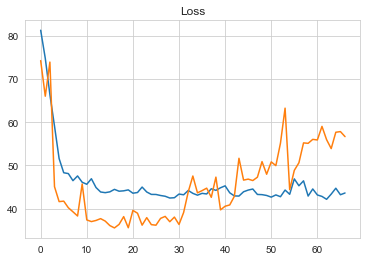

In [146]:
# Visualization
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [147]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 35.55%


In [148]:
X_test

status  propertyType  baths  fireplace    city      sqft  zipcode  \
128218     2.0           8.0    1.0          0   397.0  1.096405   1175.0   
94724      2.0           9.0    1.0          0   317.0 -0.539722   2729.0   
199284     5.0           0.0    0.0          0   939.0 -0.860888   1146.0   
233831     2.0           8.0    1.0          0   291.0  0.422845   1279.0   
313964     2.0           8.0    1.0          1   819.0  0.557779   3240.0   
...        ...           ...    ...        ...     ...       ...      ...   
126688     0.0           0.0   -1.0          0  1597.0 -0.963746    451.0   
27171      5.0          10.0    1.0          0   257.0  0.435202    795.0   
14645      3.0           8.0   -0.5          0   183.0 -0.719850    119.0   
303302     2.0           0.0    0.0          0   367.0 -0.555700   2411.0   
231076     2.0           8.0    1.0          0  1319.0  0.450028   2795.0   

        beds  state  PrivatePool  Heating  Parking  max_rating  \
128218   1.0    5.0            1      1.0        1    0.666667   
94724    0.0   28.0            0      1.0        1    0.666667   
199284  -1.0    5.0            0      1.0        1   -0.333333   
233831   1.0    5.0            0      2.0        1   -0.666667   
313964   1.0   20.0            0      1.0        1   -0.333333   
...      ...    ...          ...      ...      ...         ...   
126688  -1.0    3.0            0      1.0        1   -0.666667   
27171    0.0   18.0            0      4.0        0    0.000000   
14645    0.0   21.0            0      4.0        0   -0.666667   
303302  -1.0   28.0            0      1.0        1   -1.333333   
231076   0.0   28.0            0      1.0        1    0.333333   

        Price_sqft_state  Price_sqft_city  Price_sqft_zip  
128218          0.322829         0.547370        0.406959  
94724          -0.677171        -0.166022       -0.021478  
199284          0.322829         3.180640        1.184313  
233831          0.322829         0.244236       -0.180739  
313964         -0.180439         0.085652        0.053164  
...                  ...              ...             ...  
126688          3.801021         2.425927        1.705909  
27171          -0.698013         0.015589        0.633378  
14645           4.661588         3.747167        0.839096  
303302         -0.677171         0.349511       -0.306229  
231076         -0.677171        -0.422198       -0.419570  

[87680 rows x 16 columns]

In [157]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87680 entries, 128218 to 231076
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   status            87680 non-null  float64
 1   propertyType      87680 non-null  float64
 2   baths             87680 non-null  float64
 3   fireplace         87680 non-null  int64  
 4   city              87680 non-null  float64
 5   sqft              87680 non-null  float64
 6   zipcode           87680 non-null  float64
 7   beds              87680 non-null  float64
 8   state             87680 non-null  float64
 9   PrivatePool       87680 non-null  int64  
 10  Heating           87680 non-null  float64
 11  Parking           87680 non-null  int64  
 12  max_rating        87680 non-null  float64
 13  Price_sqft_state  87680 non-null  float64
 14  Price_sqft_city   87680 non-null  float64
 15  Price_sqft_zip    87680 non-null  float64
dtypes: float64(13), int64(3)
memory us

In [160]:
list(X_test.columns)

['status',
 'propertyType',
 'baths',
 'fireplace',
 'city',
 'sqft',
 'zipcode',
 'beds',
 'state',
 'PrivatePool',
 'Heating',
 'Parking',
 'max_rating',
 'Price_sqft_state',
 'Price_sqft_city',
 'Price_sqft_zip']